<a href="https://colab.research.google.com/github/SNEHA-67/comp215/blob/main/labs/lab03-classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 3
----------------
#### Name(s): Sneha & Manmeet Sharma
#### Date: 22-01-2025

By the end of this lab you should be able to:
  * use a `class` to organize related data and functions
  * identify a `record` as a related collection of data, with fields for each data value

During this lab, you will be introduced to the following:
  * the `@dataclass` decorator to simplify class definition for classes that primarily encapsulate a data structure.
  * the `@classmethod` decorator to create 'object factories'.
  * plotting frequency distributions in `matplotlib`



## Near Earth Objects (with classes)

We'll continue working with Near Earth Object data using NASA's API: https://api.nasa.gov/.  In this lab we will define an Asteroid class to help us structure the data for easier data analysis.  Here's a brief review from Lab 2 on how to use the API.  

In [33]:
# import necessary modules
import datetime, json, requests
from dataclasses import dataclass
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

### Review: make an API query

Here's a query that gets the record for a single NEO that recently passed by.  Read these functions carefully to be sure you know what they are returning.  Note the nested for loop structure in the return statement of the `get_neos` function - be sure to understand what it is doing.  You might want to add some more `pprint` statements to be sure you understand the data structures.

In [34]:
API_KEY = 'DEMO_KEY'  # substitute your API key here

def get_neos(start_date):
    """ Return a list of NEO for the week starting at start_date """
    url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&api_key={API_KEY}'
    # Fetch last week's NEO feed
    response = requests.request("GET", url, headers={}, data={})
    data = json.loads(response.text)
    print(f'{data["element_count"]} Near Earth Objects found for week of {start_date}')
    return [neo for dated_records in data['near_earth_objects'].values() for neo in dated_records ]

def get_neo(id):
    """ Return a NEO record for the given id """
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{id}?api_key={API_KEY}'
    response = requests.request("GET", url, headers={}, data={})
    return json.loads(response.text)

week_start = '2023-01-15'
neos = get_neos(week_start)
assert len(neos) > 0, f'Oh oh!  No NEOs found for {week_start}'
neo = get_neo(neos[-1]['id'])  # get the very latest NEO
pprint(neo)

KeyError: 'element_count'

## Exercise 1:  Define an Asteroid class

Define a simple Asteroid class with some basic state variables for a single NEO.  Your Asteroid class should define at least 4 "state variables:”

    id
    name
    estimated_diameter (m)
    is_potentially_hazardous (bool)

Operations must include:
* `__init__(self, ...)` method to initialize a new Asteroid object with specific data values
* `__str__(self)`, and `__repr__(self)` methods that return nicely formatted string representations of the object.

Write a little code to test your new class.

In [3]:
# Ex.1 your code here
class Asteroid:
    def __init__(self, id, name, estimated_diameter, is_potentially_hazardous):
        """Initialize an Asteroid object with specific attributes."""
        self.id = id
        self.name = name
        self.estimated_diameter = estimated_diameter  # in meters
        self.is_potentially_hazardous = is_potentially_hazardous  # boolean

    def __str__(self):
        """Return a nicely formatted string representation of the Asteroid object."""
        hazard_status = "Yes" if self.is_potentially_hazardous else "No"
        return (f"Asteroid ID: {self.id}\n"
                f"Name: {self.name}\n"
                f"Estimated Diameter: {self.estimated_diameter:.2f} meters\n"
                f"Potentially Hazardous: {hazard_status}")

    def __repr__(self):
        """Return a formal string representation of the Asteroid object."""
        return (f"Asteroid(id='{self.id}', "
                f"name='{self.name}', "
                f"estimated_diameter={self.estimated_diameter}, "
                f"is_potentially_hazardous={self.is_potentially_hazardous})")

# Test code
if __name__ == "__main__":
    # Create an example Asteroid object
    test_asteroid = Asteroid(
        id="123456",
        name="Test Asteroid",
        estimated_diameter=1500.5,
        is_potentially_hazardous=True
    )

    # Print the string representation
    print(test_asteroid)

    # Print the repr representation
    print(repr(test_asteroid))


Asteroid ID: 123456
Name: Test Asteroid
Estimated Diameter: 1500.50 meters
Potentially Hazardous: Yes
Asteroid(id='123456', name='Test Asteroid', estimated_diameter=1500.5, is_potentially_hazardous=True)


## Exercise 2: Make a histogram

Create a list of all the Asteroid objects from this week's NEO feed and use the list to create a histogram to visualize the distribution of Asteroid diameters.  To create the historgram use the `hist()` method in the `matplotlib.pyplot` module.

117 Near Earth Objects found for week of 2023-01-15


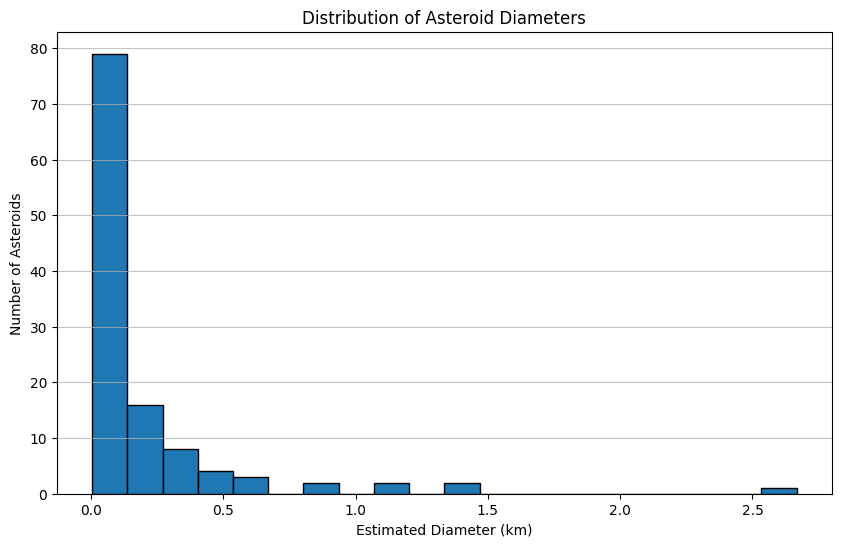

In [4]:
# Ex.2 your code here
week_start = '2023-01-15'
neos = get_neos(week_start)
assert len(neos) > 0, f'No NEOs found for {week_start}'

# Create a list of Asteroid objects
asteroids = []
for neo in neos:
    estimated_diameter = neo['estimated_diameter']['kilometers']['estimated_diameter_max']  # Using max diameter in km
    is_potentially_hazardous = neo.get('is_potentially_hazardous', False)  # Use .get() to avoid KeyError

    asteroid = Asteroid(
        id=neo['id'],
        name=neo['name'],
        estimated_diameter=estimated_diameter,
        is_potentially_hazardous=is_potentially_hazardous
    )
    asteroids.append(asteroid)

# Extract diameters for the histogram
diameters = [asteroid.estimated_diameter for asteroid in asteroids]

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(diameters, bins=20, edgecolor='black')
plt.title('Distribution of Asteroid Diameters')
plt.xlabel('Estimated Diameter (km)')
plt.ylabel('Number of Asteroids')
plt.grid(axis='y', alpha=0.75)
plt.show()


## Exercise 3: Use `@dataclass` and `@classmethod` to do the same thing

Now that you know how to define a simple class, we are going to use a use decorators to simplify (ie. shorten) our class definitions.  You will redefine the Asteroid class in this exercise.  Note that having two different definitions of a class in a single piece of code is very bad practice. I am asking you to do it here just so that you can see the differt ways to define classes.

 1. Use the `@dataclass` decorator from the `dataclasses` module to define the Asteroid class.  The `@dataclass` decorator will automatically generate some of the commonly used methods, like `__init()__`, `__repr()__`, and `__eq()__`.  The definition should start like this:
    ```
    @dataclass
    class Asteroid:
      ...
    ```
Write a little code to test your new class.
  

 2. Use the `@classmethod` decorator to construct a `from_NEO()` 'factory method' inside your Asteroid class that creates Asteroid objects from the NEO API.  The method should take the id for a single NEO, fetche the NEO record from API, constructs a single Asteroid object, and return the Asteroid object representing that NEO.  This kind of method is called a “Factory” because it constructs an object from raw materials.  The object factory method should start like this:
    ```
    @classmethod
    from_NEO(cls, neo_id):
        ...
    ```
Write a little code to test your new method.

 3. Use your new Asteroid class to create a list of Asteroid objects.  Use this list to create the same historgram as in Exercise 2.  




117 Near Earth Objects found for week of 2023-01-15


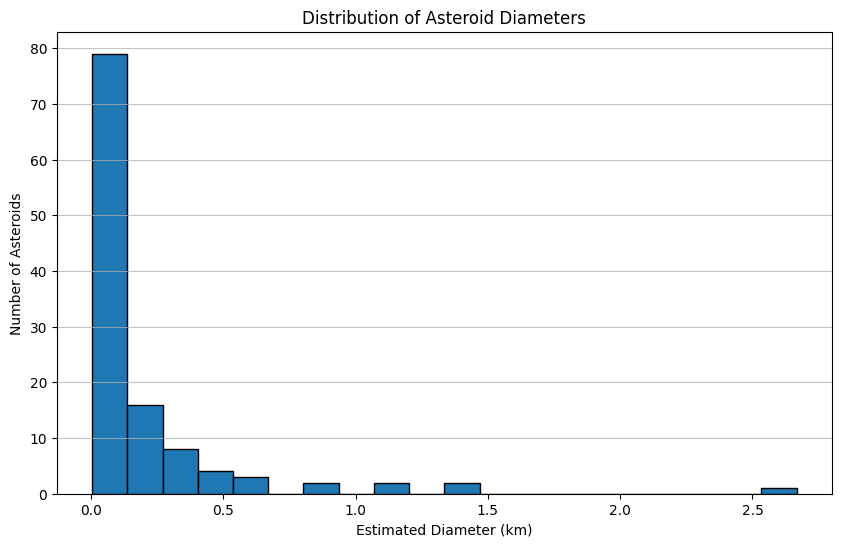

In [5]:
# Ex.3 your code here
@dataclass
class Asteroid:
    """ Class to represent an Asteroid with necessary attributes """
    id: str
    name: str
    estimated_diameter: float  # in meters
    is_potentially_hazardous: bool

    @classmethod
    def from_NEO(cls, neo):
        """ Factory method to create an Asteroid from NEO data """
        estimated_diameter = neo['estimated_diameter']['kilometers']['estimated_diameter_max']
        is_potentially_hazardous = neo.get('is_potentially_hazardous', False)
        return cls(
            id=neo['id'],
            name=neo['name'],
            estimated_diameter=estimated_diameter,
            is_potentially_hazardous=is_potentially_hazardous
        )

# Fetch NEO data and create a list of Asteroid objects
week_start = '2023-01-15'
neos = get_neos(week_start)
assert len(neos) > 0, f'Oh oh! No NEOs found for {week_start}'

# Create a list of Asteroid objects using the factory method
asteroids = [Asteroid.from_NEO(neo) for neo in neos]

# Extract diameters for the histogram
diameters = [asteroid.estimated_diameter for asteroid in asteroids]

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(diameters, bins=20, edgecolor='black')
plt.title('Distribution of Asteroid Diameters')
plt.xlabel('Estimated Diameter (km)')
plt.ylabel('Number of Asteroids')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Challenge Exercise:

One of your esteemed astromoner collegues has a theory that there is a correlation between the diameter and the orbital period of an asteroid.  Add the `orbital_period` data from the NEO API to your Asteroid class definition and use it to plot the orbital period (in years) versus the estimated diameter (in m) of all the asteroids from this week's NEO record.  Do you see a correlation?

In [32]:
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

API_KEY = 'DEMO_KEY'  # Substitute your API key here

def get_neos(start_date):
    """Return a list of NEOs for the week starting at start_date."""
    url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&api_key={API_KEY}'
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Error fetching NEOs: {response.status_code}")
        return []

    data = json.loads(response.text)
    print(f'{data["element_count"]} Near Earth Objects found for week of {start_date}')
    return [neo for dated_records in data['near_earth_objects'].values() for neo in dated_records]

def get_neo(id):
    """Return a NEO record for the given id."""
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{id}?api_key={API_KEY}'
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Error fetching NEO with ID {id}: {response.status_code}")
        return {}

    return json.loads(response.text)

# Step 1: Define the Asteroid class
class Asteroid:
    def __init__(self, name, diameter, orbital_period):
        self.name = name
        self.diameter = diameter  # Diameter in meters
        self.orbital_period = orbital_period  # Orbital period in days

    def __repr__(self):
        return f"Asteroid(name={self.name}, diameter={self.diameter}, orbital_period={self.orbital_period})"

# Step 2: Fetch NEO data for the week starting from a specific date
week_start = '2023-01-15'
neos = get_neos(week_start)

# Ensure we have NEOs to work with
assert len(neos) > 0, f'Oh oh! No NEOs found for {week_start}'

# Step 3: Create a list of Asteroid objects
asteroids = []

for neo in neos:
    neo_details = get_neo(neo['id'])
    if neo_details:
        name = neo_details.get('name')
        diameter = neo_details.get('estimated_diameter', {}).get('meters', {}).get('estimated_diameter_max', 0)
        orbital_data = neo_details.get('orbital_data', {})
        orbital_period = orbital_data.get('orbital_period', 0.0)  # Get orbital period in days

        # Create an Asteroid object and add it to the list
        asteroid = Asteroid(name, diameter, orbital_period)
        asteroids.append(asteroid)

# Step 4: Prepare data for plotting
diameters = [asteroid.diameter for asteroid in asteroids]
orbital_periods = [asteroid.orbital_period for asteroid in asteroids]

# Step 5: Create the scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(diameters, orbital_periods, alpha=0.6, s=100)
plt.title('Orbital Period vs. Diameter of Asteroids')
plt.xlabel('Diameter (m)')
plt.ylabel('Orbital Period (days)')
plt.grid(True)

# Step 6: Show the plot
plt.show()

# Step 7: Calculate and display the correlation coefficient
correlation_coefficient = np.corrcoef(diameters, orbital_periods)[0, 1]
print(f'Correlation coefficient: {correlation_coefficient}')


Error fetching NEOs: 429


AssertionError: Oh oh! No NEOs found for 2023-01-15